# Tutorial 3: Running Quantization-Aware Training (QAT) on Bert

In this tutorial, we'll build on top of Tutorial 2 by taking the Bert model fine tuned for sequence classification and running Mase's quantization pass. First, we'll run simple Post-Training Quantization (PTQ) and see how much accuracy drops. Then, we'll run some further training iterations of the quantized model (i.e. QAT) and see whether the accuracy of the trained quantized model approaches the accuracy of the original (full-precision) model.

In [1]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [ ]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

If you have previously ran the tutorial on LoRA Finetuning, run the following cell to import the fine tuned checkpoint.

In [3]:
from pathlib import Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"{Path.home()}/adlsystems/tutorial_2_lora")

/rds/general/user/jj21/home/adlsystems/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node fin

## Post-Training Quantization (PTQ)

Here, we simply quantize the model and evaluate the effect in its accuracy. First, let's evaluate the model accuracy before quantization (if you're coming from Tutorial 2, this should be the same as the post-LoRA evaluation accuracy). As seen in Tutorial 2, we can use the `get_tokenized_dataset` and `get_trainer` utilities to generate a HuggingFace `Trainer` instance for training and evaluation.

In [4]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")
      
baseline_accuracy = eval_results['eval_accuracy']

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/rds/general/user/jj21/home/adlsystems/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.86876


To run the quantization pass, we pass a quantization configuration dictionary as argument. This defines the quantization mode, numerical format and precision for each operator in the graph. We'll run the quantization in "by type" mode, meaning nodes are quantized according to their `mase_op`. Other modes include by name and by regex name. We'll quantize all activations, weights and biases in the model to fixed-point with the same precision. This may be sub-optimal, but works as an example. In future tutorials, we'll see how to run the `search` flow in `Mase` to find optimal quantization configurations to minimize accuracy loss.

In [13]:
def generate_quantization_config(bit_width):
    """
    Generates a quantization configuration for a given bit-width.
    """
    return {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # Data configuration
                "data_in_width": bit_width,
                "data_in_frac_width": bit_width // 2,  # Half for fractional part
                # Weight configuration
                "weight_width": bit_width,
                "weight_frac_width": bit_width // 2,  # Half for fractional part
                # Bias configuration
                "bias_width": bit_width,
                "bias_frac_width": bit_width // 2,  # Half for fractional part
            }
        },
    }

In [6]:
# Performing some house keeping for better output

import warnings
import logging

class SuppressWarningsAndLogging:
    def __init__(self, logger_name=None, log_level=logging.ERROR):
        self.logger = logging.getLogger(logger_name) if logger_name else None
        self.log_level = log_level
        self.original_log_level = self.logger.level if self.logger else None

    def __enter__(self):
        # Suppress warnings
        self.warnings_context = warnings.catch_warnings()
        self.warnings_context.__enter__()
        warnings.simplefilter("ignore")

        # Suppress logging if a logger is specified
        if self.logger:
            self.logger.setLevel(self.log_level)

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore warnings
        self.warnings_context.__exit__(exc_type, exc_value, traceback)

        # Restore original logging level
        if self.logger:
            self.logger.setLevel(self.original_log_level)

Lets try different quantisation and see their accuracy when performing PTQ

In [15]:
import chop.passes as passes
import warnings


print("Post Training quantisation:\n")

min_bit_width = 4
max_bit_width = 32

bit_width_list = []
accuracy_list = []

with SuppressWarningsAndLogging("accelerate.utils.other", logging.ERROR):
    for bit_width in range(min_bit_width, max_bit_width + 1):
            quantization_config = generate_quantization_config(bit_width)
            print(f"Bit-width: {bit_width}")
            #print(f"Quantization Config: {config}")

            mg_PTQ, _ = passes.quantize_transform_pass(
                mg,
                pass_args=quantization_config,
            )

            trainer = get_trainer(
                model=mg_PTQ.model,
                tokenized_dataset=dataset,
                tokenizer=tokenizer,
                evaluate_metric="accuracy",
            )
            eval_results = trainer.evaluate()
            print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")
                  
            bit_width_list.append(bit_width)
            accuracy_list.append(eval_results['eval_accuracy']/baseline_accuracy)

            print("-" * 50)


Post Training quantisation:

Bit-width: 4


Evaluation accuracy: 0.5
--------------------------------------------------
Bit-width: 5


Evaluation accuracy: 0.5
--------------------------------------------------
Bit-width: 6


Evaluation accuracy: 0.76548
--------------------------------------------------
Bit-width: 7


Evaluation accuracy: 0.79052
--------------------------------------------------
Bit-width: 8


Evaluation accuracy: 0.86656
--------------------------------------------------
Bit-width: 9


Evaluation accuracy: 0.86776
--------------------------------------------------
Bit-width: 10


Evaluation accuracy: 0.868
--------------------------------------------------
Bit-width: 11


Evaluation accuracy: 0.868
--------------------------------------------------
Bit-width: 12


Evaluation accuracy: 0.865
--------------------------------------------------
Bit-width: 13


Evaluation accuracy: 0.865
--------------------------------------------------
Bit-width: 14


Evaluation accuracy: 0.86876
--------------------------------------------------
Bit-width: 15


Evaluation accuracy: 0.86876
--------------------------------------------------
Bit-width: 16


Evaluation accuracy: 0.86816
--------------------------------------------------
Bit-width: 17


Evaluation accuracy: 0.86816
--------------------------------------------------
Bit-width: 18


Evaluation accuracy: 0.86872
--------------------------------------------------
Bit-width: 19


Evaluation accuracy: 0.86872
--------------------------------------------------
Bit-width: 20


Evaluation accuracy: 0.86912
--------------------------------------------------
Bit-width: 21


Evaluation accuracy: 0.86912
--------------------------------------------------
Bit-width: 22


Evaluation accuracy: 0.86912
--------------------------------------------------
Bit-width: 23


Evaluation accuracy: 0.86912
--------------------------------------------------
Bit-width: 24


Evaluation accuracy: 0.86868
--------------------------------------------------
Bit-width: 25


Evaluation accuracy: 0.86868
--------------------------------------------------
Bit-width: 26


Evaluation accuracy: 0.8688
--------------------------------------------------
Bit-width: 27


Evaluation accuracy: 0.8688
--------------------------------------------------
Bit-width: 28


Evaluation accuracy: 0.86876
--------------------------------------------------
Bit-width: 29


Evaluation accuracy: 0.86876
--------------------------------------------------
Bit-width: 30


Evaluation accuracy: 0.86872
--------------------------------------------------
Bit-width: 31


Evaluation accuracy: 0.86872
--------------------------------------------------
Bit-width: 32


Evaluation accuracy: 0.86876
--------------------------------------------------


[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
[0.5755329435056863, 0.5755329435056863, 0.8811179151894655, 0.9099406050002302, 0.997467655048575, 0.9988489341129886, 0.9991251899258714, 0.9991251899258714, 0.9956719922648373, 0.9956719922648373, 1.0, 1.0, 0.9993093604677933, 0.9993093604677933, 0.9999539573645196, 0.9999539573645196, 1.0004143837193242, 1.0004143837193242, 1.0004143837193242, 1.0004143837193242, 0.9999079147290392, 0.9999079147290392, 1.0000460426354805, 1.0000460426354805, 1.0, 1.0, 0.9999539573645196, 0.9999539573645196, 1.0]


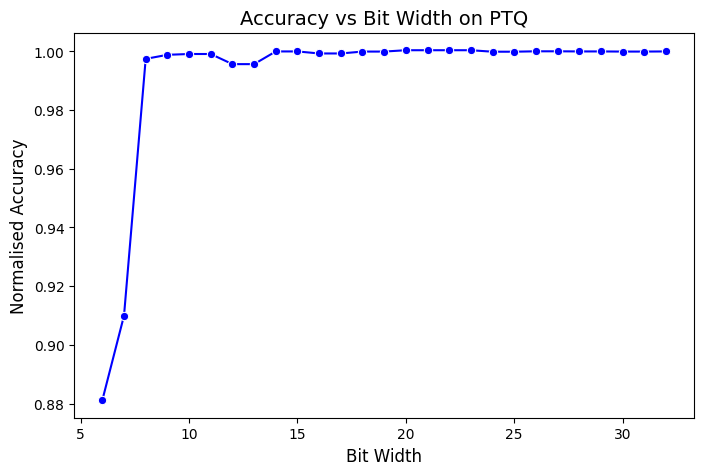

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

print(bit_width_list)
print(accuracy_list)


plt.figure(figsize=(8, 5))
sns.lineplot(x=bit_width_list[2:], y=accuracy_list[2:], marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Bit Width', fontsize=12)
plt.ylabel('Normalised Accuracy', fontsize=12)
plt.title('Accuracy vs Bit Width on PTQ', fontsize=14)
plt.savefig("PTQ.png")

We can save the current checkpoint for future reference (optional).

In [11]:
from pathlib import Path

mg.export(f"{Path.home()}/adlsystems/tutorial_3_ptq")

INFO     Exporting MaseGraph to /rds/general/user/jj21/home/adlsystems/tutorial_3_ptq.pt, /rds/general/user/jj21/home/adlsystems/tutorial_3_ptq.mz
INFO     Exporting GraphModule to /rds/general/user/jj21/home/adlsystems/tutorial_3_ptq.pt
INFO     Exporting MaseMetadata to /rds/general/user/jj21/home/adlsystems/tutorial_3_ptq.mz


## Quantization-Aware Training (QAT)

You should have seen in the last section that quantization can lead to a significant drop in accuracy. Next, we'll run QAT to evaluate whether this performance gap can be reduced. To run QAT in Mase, all you need to do is include the model back in your training loop after running the quantization pass.

In [12]:
# Evaluate accuracy
trainer.train()
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

Step,Training Loss
500,0.278000
1000,0.248600
1500,0.298700
2000,0.311900
2500,0.318600
3000,0.365700


Evaluation accuracy: 0.87252


We can see the accuracy of the quantized model can match (or sometimes exceed) the full precision model, with a much lower memory requirement to store the weights. Finally, save the final checkpoint for future tutorials.

In [13]:
from pathlib import Path

mg.export(f"{Path.home()}/adlsystems/tutorial_3_qat")

INFO     Exporting MaseGraph to /rds/general/user/jj21/home/adlsystems/tutorial_3_qat.pt, /rds/general/user/jj21/home/adlsystems/tutorial_3_qat.mz
INFO     Exporting GraphModule to /rds/general/user/jj21/home/adlsystems/tutorial_3_qat.pt
INFO     Exporting MaseMetadata to /rds/general/user/jj21/home/adlsystems/tutorial_3_qat.mz


In [22]:
print("Quantisation Aware Training:\n")

min_bit_width = 4
max_bit_width = 32

bit_width_list_qat = []
accuracy_list_qat = []

with SuppressWarningsAndLogging("accelerate.utils.other", logging.ERROR):
    for bit_width in range(min_bit_width, max_bit_width + 1, 2):
            quantization_config = generate_quantization_config(bit_width)
            print(f"Bit-width: {bit_width}")
            #print(f"Quantization Config: {config}")

            mg_PTQ, _ = passes.quantize_transform_pass(
                mg,
                pass_args=quantization_config,
            )

            trainer = get_trainer(
                model=mg_PTQ.model,
                tokenized_dataset=dataset,
                tokenizer=tokenizer,
                evaluate_metric="accuracy",
            )
            trainer.train()
            eval_results = trainer.evaluate()
            print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")
                  
            bit_width_list_qat.append(bit_width)
            accuracy_list_qat.append(eval_results['eval_accuracy']/baseline_accuracy)

            print("-" * 50)

Quantisation Aware Training:

Bit-width: 4


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.682600
3000,0.625300


Evaluation accuracy: 0.83172
--------------------------------------------------
Bit-width: 6


Step,Training Loss
500,0.245900
1000,0.043400
1500,0.052700
2000,0.067100
2500,0.130600
3000,0.353300


Evaluation accuracy: 0.8486
--------------------------------------------------
Bit-width: 8


Step,Training Loss
500,0.005700
1000,0.006800
1500,0.009200
2000,0.031300
2500,0.071200
3000,0.294100


Evaluation accuracy: 0.84604
--------------------------------------------------
Bit-width: 10


Step,Training Loss
500,0.004300
1000,0.004700
1500,0.004200
2000,0.015600
2500,0.057700
3000,0.288000


Evaluation accuracy: 0.84504
--------------------------------------------------
Bit-width: 12


Step,Training Loss
500,0.001400
1000,0.006300
1500,0.005900
2000,0.015000
2500,0.035000
3000,0.258800


Evaluation accuracy: 0.84372
--------------------------------------------------
Bit-width: 14


Step,Training Loss
500,0.001300
1000,0.012200
1500,0.003300
2000,0.010500
2500,0.030300
3000,0.262300


Evaluation accuracy: 0.84344
--------------------------------------------------
Bit-width: 16


Step,Training Loss
500,0.001300
1000,0.014200
1500,0.004600
2000,0.016100
2500,0.025000
3000,0.237300


Evaluation accuracy: 0.83932
--------------------------------------------------
Bit-width: 18


Step,Training Loss
500,0.001300
1000,0.008400
1500,0.001600
2000,0.007000
2500,0.017500
3000,0.231400


Evaluation accuracy: 0.83836
--------------------------------------------------
Bit-width: 20


Step,Training Loss
500,0.001300
1000,0.008100
1500,0.002900
2000,0.007600
2500,0.018000
3000,0.203200


Evaluation accuracy: 0.8364
--------------------------------------------------
Bit-width: 22


Step,Training Loss
500,0.001300
1000,0.002500
1500,0.005500
2000,0.005800
2500,0.013900
3000,0.207400


Evaluation accuracy: 0.83724
--------------------------------------------------
Bit-width: 24


Step,Training Loss
500,0.001200
1000,0.002500
1500,0.009100
2000,0.001800
2500,0.015100
3000,0.192800


Evaluation accuracy: 0.83308
--------------------------------------------------
Bit-width: 26


Step,Training Loss
500,0.001200
1000,0.002500
1500,0.002200
2000,0.008500
2500,0.014200
3000,0.189900


Evaluation accuracy: 0.83236
--------------------------------------------------
Bit-width: 28


Step,Training Loss
500,0.001200
1000,0.012800
1500,0.001700
2000,0.007400
2500,0.007900
3000,0.171900


Evaluation accuracy: 0.83096
--------------------------------------------------
Bit-width: 30


Step,Training Loss
500,0.001200
1000,0.002400
1500,0.000100
2000,0.005900
2500,0.008200
3000,0.169400


Evaluation accuracy: 0.83128
--------------------------------------------------
Bit-width: 32


Step,Training Loss
500,0.001200
1000,0.002400
1500,0.000700
2000,0.007300
2500,0.006100
3000,0.158000


Evaluation accuracy: 0.83088
--------------------------------------------------


[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
[0.9573645195450988, 0.9767945117178508, 0.9738477830471016, 0.9726967171600903, 0.9711773101892353, 0.9708550117408721, 0.9661126202863851, 0.9650075970348543, 0.962751507896312, 0.9637184032414016, 0.9589299691514344, 0.958101201712786, 0.9564897094709702, 0.9568580505548138, 0.9563976242000092]


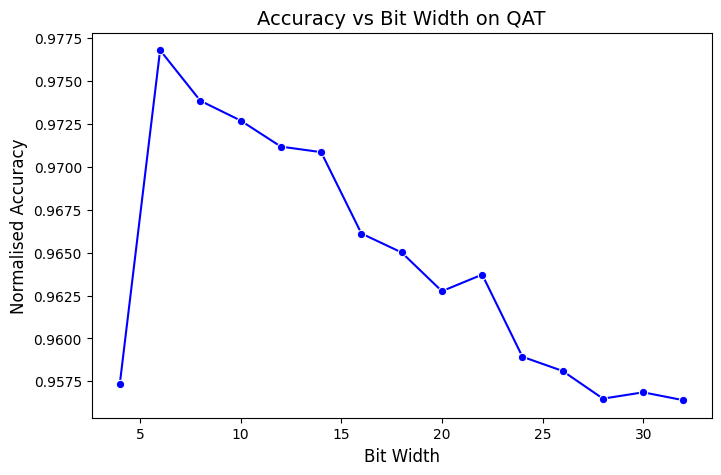

In [24]:
print(bit_width_list_qat)
print(accuracy_list_qat)

plt.figure(figsize=(8, 5))
sns.lineplot(x=bit_width_list_qat, y=accuracy_list_qat, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Bit Width', fontsize=12)
plt.ylabel('Normalised Accuracy', fontsize=12)
plt.title('Accuracy vs Bit Width on QAT', fontsize=14)
plt.savefig("QAT.png")